# **AI Final_Project_12150981_박중규**



### 라이브러리 import

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

### 구글 드라이브 마운트 시키기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### fer2013.csv 파일 경로 지정

In [ ]:
fer2013_dataset_file_path = 'drive/My Drive/Project/fer2013.csv'

### fer2013 Dataset을 통해 train 이미지, validation 이미지, test 이미지 세팅

In [ ]:
# 데이터 학습을 시킬 이미지를 담을 변수
train_images = []
train_labels = []

# validation를 위한 이미지를 담을 변수
val_images = []
val_labels = []

# 얼굴인식 성능을 test하기 위한 이미지를 담을 변수
test_images = []
test_labels = []

# 'fer2013.csv'파일을 반복문을 통해 각 행을 접근하여 필요한 데이터를 가져오기
# 'fer2013.csv'파일의 구조
# 1번 째 열 : 얼굴이 나타내는 감정의 이름(label)
# 2번 째 열 : 이미지의 픽셀값
# 3번 째 열 : 이미지의 용도(Training, Validation, Testing)
with open(fer2013_dataset_file_path) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  # 반복문을 통해 각 행에 접근
  for row_id, row in enumerate(csv_reader):
    if row_id == 0:
      continue
    # 감정 label은 7가지로 구성(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
    label = np.zeros(7)
    label[int(row[0])] = 1

    image = list(map(int, row[1].split(' ')))
    
    # Usage별로 구분하여 각 변수에 추가
    if row[2] == 'Training':
      train_labels.append(label)
      train_images.append(image)
    elif row[2] == 'PublicTest':
      test_labels.append(label)
      test_images.append(image)
    elif row[2] == 'PrivateTest':
      val_labels.append(label)
      val_images.append(image)

# numpy 배열로 변경, 이미지 파일은 48x48x1 크기로 변경
train_labels = np.asarray(train_labels, dtype=np.float32)
train_images = np.asarray(train_images, dtype=np.float32).reshape(-1, 48, 48, 1)

val_labels = np.asarray(val_labels, dtype=np.float32)
val_images = np.asarray(val_images, dtype=np.float32).reshape(-1, 48, 48, 1)

test_labels = np.asarray(test_labels, dtype=np.float32)
test_images = np.asarray(test_images, dtype=np.float32).reshape(-1, 48, 48, 1)

# 정규화 : 이미지의 스케일을 [0, 1]범위로 조정
train_images /= 255
val_images /= 255
test_images /= 255


### Dataset 인스턴스 예시 출력

Label 배열(7가지): [0. 0. 0. 1. 0. 0. 0.] 
Label: 3 
감정: Happy 
이미지: (48, 48, 1)


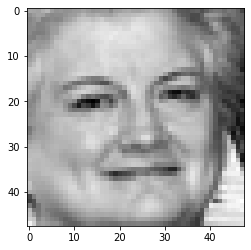

In [ ]:
# 감정종류
emotions = {
    0: 'Angry', 
    1: 'Disgust',
    2: 'Fear', 
    3: 'Happy',
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

# 100번째 이미지와 감정이름을 출력. 이미지 출력 시 matplotlib 라이브러리 사용
index = 100
print('Label 배열(7가지):', train_labels[index], 
      '\nLabel:', np.argmax(train_labels[index]),
      '\n감정:', emotions[np.argmax(train_labels[index])],
      '\n이미지:', train_images[index].shape)
plt.imshow(train_images[index].reshape(48, 48), cmap='gray')
plt.show()

### 데이터 학습을 위한 2가지 CNN 모델 : 기존 모델, 개선 모델

### 1. 기존 모델

In [ ]:
input_shape = (48, 48, 1)
num_labels = 7

# 학습 시간 단축을 위해 filter수를 감소
num_features = 16

# CNN모델 생성
model_original = Sequential()

# Layer1
# Convolutional Layer을 통해 이미지의 특징 추출, ReLu 활성화 함수 사용
model_original.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, 
                 data_format='channels_last', kernel_regularizer=l2(0.01)))
model_original.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
# 배치정규화를 통해 신경망 안에 포함되어 학습 시 평균과 분산을 조정하는 과정이 같이 조절. 각 레이어마다 정규화 하는 레이어를 두어, 변형된 분포가 나오지 않도록 조절
model_original.add(BatchNormalization())
# MaxPooling을 이용하여 차원을 낮추어 특정 feature 강조
model_original.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Dropout Layer를 통해 복잡도를 줄여 오버피팅을 방지
model_original.add(Dropout(0.5))

# Layer2
model_original.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_original.add(Dropout(0.5))

# Layer3
model_original.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_original.add(Dropout(0.5))

# Layer4
model_original.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_original.add(BatchNormalization())
model_original.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_original.add(Dropout(0.5))

# 이미지 분류를 위해 Fully Connected Layer를 통해 감소된 차원의 input과 output을 연결
model_original.add(Flatten())
model_original.add(Dense(2*2*2*num_features, activation='relu'))
model_original.add(Dropout(0.4))
model_original.add(Dense(2*2*num_features, activation='relu'))
model_original.add(Dropout(0.4))
model_original.add(Dense(2*num_features, activation='relu'))
model_original.add(Dropout(0.5))

# 분류 수행
model_original.add(Dense(num_labels, activation='softmax'))

# 요약 출력
model_original.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 32)        4

### 모델에 데이터 학습 시키기(기존 모델)

In [ ]:
batch_size = 512
epochs = 10

# adam 옵티마이저와 categorical crossentropy loss를 통해 모델 컴파일링
model_original.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

# 기존 모델을 이용하여 데이터 학습
train_history = model_original.fit(
    train_images, train_labels, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(val_images, val_labels), 
    verbose=1)

Epoch 1/10
57/57 [==============================] - 206s 4s/step - loss: 2.3642 - accuracy: 0.1454 - val_loss: 1.9397 - val_accuracy: 0.2449
Epoch 2/10
57/57 [==============================] - 203s 4s/step - loss: 1.9426 - accuracy: 0.2094 - val_loss: 1.8853 - val_accuracy: 0.2449
Epoch 3/10
57/57 [==============================] - 203s 4s/step - loss: 1.9055 - accuracy: 0.2272 - val_loss: 1.8581 - val_accuracy: 0.2449
Epoch 4/10
57/57 [==============================] - 204s 4s/step - loss: 1.8822 - accuracy: 0.2312 - val_loss: 1.8418 - val_accuracy: 0.2449
Epoch 5/10
57/57 [==============================] - 204s 4s/step - loss: 1.8637 - accuracy: 0.2367 - val_loss: 1.8466 - val_accuracy: 0.2449
Epoch 6/10
57/57 [==============================] - 204s 4s/step - loss: 1.8560 - accuracy: 0.2367 - val_loss: 1.8361 - val_accuracy: 0.2449
Epoch 7/10
57/57 [==============================] - 204s 4s/step - loss: 1.8510 - accuracy: 0.2451 - val_loss: 1.8304 - val_accuracy: 0.2449
Epoch 8/10
57

### Loss 및 Accuracy 출력(기존 모델)

In [ ]:
loss, accuracy = model_original.evaluate(test_images, test_labels, verbose=1)
print('기존 모델의 loss와 accuracy\n','Loss:', loss, '\nAccuracy:', accuracy * 100, '%')

113/113 [==============================] - 7s 59ms/step - loss: 1.8217 - accuracy: 0.2494
기존 모델의 loss와 accuracy
 Loss: 1.8216649293899536 
Accuracy: 24.937307834625244 %


### 2. 개선 모델

In [ ]:
# CNN모델 생성
model_improved = Sequential() 

# Layer1
model_improved.add(Conv2D(filters=num_features, kernel_size=(3, 3), activation='relu', padding='same',
                          name='image_array', input_shape=input_shape)) 
model_improved.add(BatchNormalization()) 
model_improved.add(Conv2D(filters=num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization())
# MaxPooling 대신에 AveragePooling을 사용
model_improved.add(AveragePooling2D(pool_size=(2, 2), padding='same')) 
model_improved.add(Dropout(.5))

# Layer2
model_improved.add(Conv2D(filters=2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization())
model_improved.add(Conv2D(filters=2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(AveragePooling2D(pool_size=(2, 2), padding='same')) 
model_improved.add(Dropout(.5))

# Layer3
model_improved.add(Conv2D(filters=2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(Conv2D(filters=2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(AveragePooling2D(pool_size=(2, 2), padding='same')) 
model_improved.add(Dropout(.5))

# Layer4
model_improved.add(Conv2D(filters=2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(Conv2D(filters=2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(AveragePooling2D(pool_size=(2, 2), padding='same')) 
model_improved.add(Dropout(.5))

# Fully Connected Layer 대신 GAP(Global Average Pooling)사용
model_improved.add(Conv2D(filters=2*2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(BatchNormalization()) 
model_improved.add(Conv2D(filters=num_labels, kernel_size=(3, 3), activation='relu', padding='same')) 
model_improved.add(GlobalAveragePooling2D())

# 분류 수행
model_improved.add(Activation('softmax', name='predictions'))

# 요약 출력
model_improved.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        160       
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 16)        2320      
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 average_pooling2d_4 (Averag  (None, 24, 24, 16)       0         
 ePooling2D)                                                     
                                                      

### 모델에 데이터 학습 시키기(개선모델)

In [ ]:
batch_size = 512
epochs = 10

# adam 옵티마이저와 categorical crossentropy loss를 통해 모델 컴파일링
model_improved.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

# 개선 모델을 이용하여 데이터 학습
train_history = model_improved.fit(
    train_images, train_labels, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(val_images, val_labels), 
    verbose=1)

Epoch 1/10
57/57 [==============================] - 239s 4s/step - loss: 1.7982 - accuracy: 0.2708 - val_loss: 1.8695 - val_accuracy: 0.2062
Epoch 2/10
57/57 [==============================] - 238s 4s/step - loss: 1.6216 - accuracy: 0.3667 - val_loss: 1.8944 - val_accuracy: 0.2449
Epoch 3/10
57/57 [==============================] - 237s 4s/step - loss: 1.5130 - accuracy: 0.4133 - val_loss: 1.8686 - val_accuracy: 0.2566
Epoch 4/10
57/57 [==============================] - 237s 4s/step - loss: 1.4377 - accuracy: 0.4470 - val_loss: 1.9783 - val_accuracy: 0.1970
Epoch 5/10
57/57 [==============================] - 237s 4s/step - loss: 1.3748 - accuracy: 0.4703 - val_loss: 1.8626 - val_accuracy: 0.2288
Epoch 6/10
57/57 [==============================] - 237s 4s/step - loss: 1.3271 - accuracy: 0.4914 - val_loss: 1.9159 - val_accuracy: 0.1708
Epoch 7/10
57/57 [==============================] - 236s 4s/step - loss: 1.2951 - accuracy: 0.5072 - val_loss: 1.7714 - val_accuracy: 0.3126
Epoch 8/10
57

### Loss 및 Accuracy 출력(개선 모델)

In [ ]:
loss, accuracy = model_improved.evaluate(test_images, test_labels, verbose=1)
print('개선 모델의 loss와 accuracy\n','Loss:', loss, '\nAccuracy:', accuracy * 100, '%')

113/113 [==============================] - 8s 66ms/step - loss: 1.2560 - accuracy: 0.5258
개선 모델의 loss와 accuracy
 Loss: 1.256030797958374 
Accuracy: 52.577316761016846 %
